# Multi-armed bandits

### Intro.

강화학습에서는 학습정보를 통해 올바른 action을 지시(instruct)하기보다는 선택가능한 action들에 대한 가치를 평가(evaluate)한다. 이것이 바로 강화학습을 다른 종류의 학습과 구분짓는 가장 중요한 특징이다. 이번 챕터에서는 일명 k-armed bandit problem이라고 불리는, 오직 하나의 state에서 독립된 k개의 action 중 하나를 선택하는, 특수한 강화학습 문제를 살펴보도록 한다. 또한 이를 통해 몇 가지 solution methods를 살펴보도록 할 것이다.

### 2.1 k-armed bandit problem

'One-armed bandit'이라는 말을 들어본 적이 있는가? 단어 그대로 해석하면 '외팔이 강도'라는 뜻인데, 이는 도박용 슬롯머신의 생김새를 본따 비꼬아 표현한 말이다.

<img src="images/one-armed_bandit.png" alt="One-armed bandits" style="width: 600px;"/>
<center>[Fig. 2] Multi-armed bandit (<a href="https://www.google.co.kr/search?q=one-armed+bandit&tbm=isch">'one-armed bandit' searched by google</a>)</center>

그렇다면 k-armed bandit이란 무엇일까? 이는 마치 k개의 슬롯머신이 내 눈 앞에 있는 것과 같은 상황을 묘사한 문제라고 볼 수 있다. 

<img src="images/multi-armed_bandit.jpg" alt="Multi-armed bandits" style="width: 300px;"/>
<center>[Fig. 2] Multi-armed bandit (<a href="https://www.microsoft.com/en-us/research/">Microsoft research</a>)</center>

아주 간단한 형태의 k-armed bandit problem을 다음과 같이 정의해보자.

1. 매 time step마다 k개의 슬롯머신 중에서 하나를 선택한다. 이는 매번 k개의 액션을 선택할 수 있는 것과 같다.
2. 선택된 슬롯머신은 고정된 확률 분포(stationary probability distribution)를 통해 수치적인(numerical) reward를 반환한다.

우리의 목표는 위 절차를 어떤 time step만큼 반복하여 reward의 총합에 대한 기댓값이 가장 높은 슬롯머신을 찾는 것이다. 시간이 흐르고 action을 반복하여 시행할수록, 우리는 점차 보상을 최대화 할 수 있으리라 여겨지는 action(the best lever)에 집중하게 될 것이다. 

참고로 오늘날의 'bandit problem'은 위의 예시 뿐만 아니라, action의 선택과 그에 대한 reward의 반환이 반복되는 문제를 총체적으로 일컫는다. 

앞서 정의한 k-armed bandit problem에서, t 시점에서 어떤 action을 선택했을때의 reward에 대한 기대값을 그 action에 대한 **value**라고 칭하고 다음과 같이 표현할 수 있다.
$$q_*(a) = E[R_t \phantom{1} | \phantom{1} A_t = a ],$$
* $R_t$: Reward on time step t, 
* $A_t$: Action on time step t

'보상을 최대화 할 수 있으리라 여겨지는 action에 집중한다.'는 말은 다른말로 action value가 가장 높은 action을 선택하겠다는 말과도 같다. 하지만 안타깝게도 대부분의 경우, 우리는 action value에 대한 정보를 사전에 가지고 있지 않을 것이다. 단지 실험을 반복하며 얻은 정보를 토대로 어떤 추정(estimate)을 할 수 있을 뿐이다. 여기서 그 추정을 $Q_t(a)$로 표현하도록 하자. $Q_t(a)$가 $q_*(a)$에 최대한 가까워진다면 객관적으로도 좋은 action을 선택할 수 있을 것이라 기대할 수 있다.

다음은 학습에서의 중요한 개념과 그에 대한 용어들을 살펴보도록 하자. Action value에 대한 추정함수 $Q_t(a)$에 대해, 매 time step에서 estimated value가 가장 높은 action이 최소한 한 개씩은 존재할 것이다. 우리는 이 action을 **greedy actions**라고 부르도록 한다. 또한 이 greedy actions 중 한가지 action을 선택하는 것을 **exploiting**이라고 한다. 한가지 유의해야 할 점은, 우리가 참고하는 $Q_t(a)$ 함수는 경험을 통한 추정치라는 것이다. 그렇기 때문에 $Q_t(a)$에 대한 신뢰도를 높이기 위해서는 때로 nongreedy actions 중 하나가 선택될 필요가 있다. 우리는 이것을 **exploring**이라고 부른다.
강화학습에서 exploitation과 exploration은 trade-off 관계에 해당한다. Exploring을 많이 하게되면 단기간 동안 받게되는 reward의 총량은 적어지겠지만, 장기적 관점에서 좋은 greedy actions를 발견하게 될 가능성이 커진다. 반면에 exploiting을 많이 하게되면 당장 받게되는 reward의 총량은 상대적으로 높아질 수 있지만, 장기적으로 현재의 greedy actions가 정말 객관적으로 좋은 actions에 해당하는지 확신하기 어려워진다. 이번 챕터에서는 k-armed bandit problem을 통해 exploitation과 exploration 사이에서 좋은 균형을 잡기위한 여러가지 방법들을 살펴보도록 하겠다. 이 주제는 강화학습에서 중점적으로 다루어지는 문제이기도 하다.

### 2.2 Action-value Methods

Action-value를 추정(estimate)하는 아주 간단한 방법에 대해 살펴보도록 하겠다. 자연스러운 접근으로는 선택한 action의 누적된 reward에 대해 평균을 내주는 방법이 있을 것이다. 이를 수식으로 표현하면 아래와 같다.
$$Q_t(a) = \frac{\text{sum of rewards when a taken prior to t}}{\text{number of times a taken prior to t}} = \frac{\Sigma_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_i = a}}{\Sigma_{i=1}^{t-1} \mathbb{1}_{A_i = a}},$$ 

* $\mathbb{1}_{predicate}$: predicate이 true면 1을 반환하고, false면 0을 반환한다.
* 분모가 0인 경우에는 $Q_t(a)$을 임의의 상수값으로 정의한다. (가령, 0)

위 공식의 분모가 무한으로 발산하게 되면 $Q_t(a)$는 $q_*(a)$로 수렴하게 될 것이다. 이 방식을 우리는 **sample-average method**라고 부른다. 그렇다면 이 추정함수는 action을 선택(action selection)하는데 있어 어떻게 이용될 수 있을까? 가장 간단한 action selection 방식은 바로 가장 높은 추정치(estimated value)를 선정하는 것이다. 이것을 **greedy action selection**이라고 부른다.
$$A_t = argmax_a Q_t(a),$$

* $argmax_a Q_t(a)$ 함수는 $Q_t(a)$을 최대화시키는 action $a$를 반환한다.

항상 greedy action selection을 한다는 것은 항상 exploiting을 하는 것과도 같다. 즉, 이 방법만을 유지하게 되면 전체 actions의 가치에 대한 추정이 어느정도의 객관성을 보이기도 전에 특정 action만을 고집하게 될 수도 있을 것이다. 그렇기 때문에 가끔씩은 exploring을 통해 non-greedy action을 고를 필요가 있다. 이렇게 대부분의 경우 greedy action을 선택하면서 가끔씩은 non-greedy action을 선택하자는 아이디어가 바로 **$\epsilon$-greedy method**이다. 이 방법을 통해 매 time step마다 $1 - \epsilon$만큼의 확률로 greedy action selection을 하고, $\epsilon$ 만큼의 확률로는 non-greedy action selection을 한다. $\epsilon$-greedy method로 무한히 많은 action selection을 하게되면 결국 모든 action $a$에 대한 $Q_t(a)$는 $q_*(a)$에 수렴할 것이고, optimal action이 선택될 확률은 $1-\epsilon$에 가깝게 수렴할 것이다. 이해를 돕기 위해 아래의 연습문제를 살펴보자.

**Excercise**. 현재 $Q_t(a) = q_*(a)$를 만족하고, 10개의 action에 대해 $\epsilon = 0.1$로 $\epsilon$-greedy action selection을 하고 있다. 이때 optimal action이 선택될 확률은 어느정도 일까?

*solution:*
1. greedy action selection에 의해 $1 - \epsilon$의 확률로 optimal action이 선택된다: $1 - \epsilon$ = $1 - 0.1$ = 0.9
2. non-greedy action selection에 의해 $\epsilon$의 확률로 10개 중 임의의 action이 선택된다. 이 중 optimal action이 선택될 확률은: $0.1 * \frac{1}{10} = 0.01$

즉, optimal action이 선택될 확률은: $0.9 + 0.01 = 0.91$

### 2.3 The 10-armed Testbed

Greedy method와 $\epsilon$-greedy method의 성능비교를 위해 간단한 실험을 해보도록 하자. 이 실험에서는 2000개의 10-armed bandit 문제를 랜덤하게 생성하여 각 time step마다의 average reward와 optimal action selection을 그래프로 출력해보도록 할 것이다. 실험을 위한 설정은 다음과 같다.

1. 10개의 action에 대한 optimal action value($q_*(a), \text{ }a=1,\dotsc,10$)의 값을 mean=0, variance=1인 normal distribution으로 생성한다.
2. 각 action에 대한 time step t에서의 reward($R_t$)는 mean=$q_*(a)$, var=1의 normal distribution을 따른다고 가정한다.
3. 2000번의 독립적인 실험을 실시한다. 각 실험은 3000번의 time step동안 이루어진다.
4. 3을 $\epsilon$ = 0.1, 0.01, 0 (greedy)에 대해 각각 실시하고 이를 그래프로 출력한다.


Testbed 9 has the highest action value: 2.782505


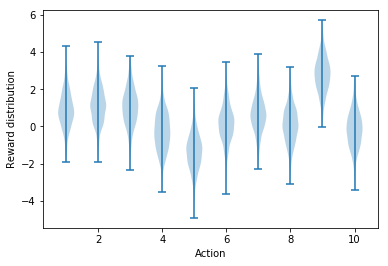

In [6]:
import numpy as np
import matplotlib.pyplot as plt

num_actions = 10 # the number of testbed
q_star = np.random.normal(0, 1, num_actions) # generate action values
optimal_action = np.argmax(q_star)
print('Testbed %d has the highest action value: %f' %(optimal_action+1, np.max(q_star)))

# print reward distribution for all testbeds
samples = []
for loc in q_star:
    samples.append(np.random.normal(loc, 1, 1000))
fig = plt.figure()
ax = plt.gca()
ax.violinplot(samples)
plt.xlabel("Action")
plt.ylabel("Reward distribution")
plt.show()

In [69]:
import random

num_trials = 2000
num_time_steps = 3000
epsilons = [0, 0.01, 0.1]

rewards = np.zeros((len(epsilons), num_trials, num_time_steps))
action_selection = np.zeros((len(epsilons), num_trials, num_time_steps))

for i, epsilon in enumerate(epsilons):
    for j in range(num_trials):
        num_action_selected = np.zeros((num_actions))
        q_est = np.zeros((num_actions)) # Q_1(a)
        
        for k in range(num_time_steps):
            # idices of greedy actions and non-greedy actions
            greedy_actions = np.argwhere(q_est == np.amax(q_est)).flatten()
            nongreedy_actions = np.argwhere(q_est != np.amax(q_est)).flatten()
            
            # epsilon-greedy method
            action = None
            if random.random() < 1 - epsilon or nongreedy_actions.shape[0] == 0:
                action = np.random.choice(greedy_actions)
            else:
                action = np.random.choice(nongreedy_actions)
                
            # reward from the normal distribution with mean = q_star(a) and std = 1
            reward = random.gauss(q_star[action], 1)
            
            # update Q_t(a)
            sum_rewards = q_est[action] * num_action_selected[action] + reward
            num_action_selected[action] += 1
            q_est[action] = sum_rewards / num_action_selected[action]
            
            # update logs
            rewards[i][j][k] = reward
            action_selection[i][j][k] = action

average_reward = np.mean(rewards, axis=1)
ratio_optimal_action = np.mean((action_selection == optimal_action), axis=1)

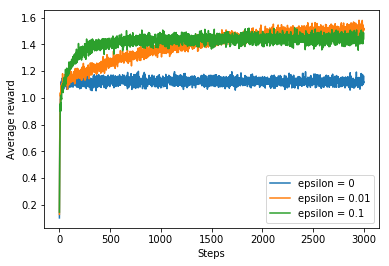

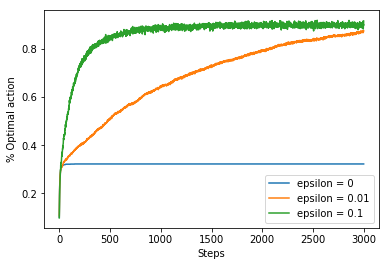

In [70]:
plt.figure(0)
for i, epsilon in enumerate(epsilons):
    plt.plot(average_reward[i], label='epsilon = '+str(epsilon))
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()

plt.figure(1)
for i, epsilon in enumerate(epsilons):
    plt.plot(ratio_optimal_action[i], label='epsilon = '+str(epsilon))
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()

plt.show()

$\epsilon = 0$ (greedy method)에서는 exploring이 전혀 없기 때문에 실제 optimal action을 찾는 것이 항상 보장되지 않는다. 위의 두 번째 그래프(the ratio of optimal action selection)를 보면 총 시도의 약 1/3정도 비율만이 optimal action을 선택하는 것을 알 수 있다. 이는 greedy method가 더 복잡한 상황에서는 더더욱 좋은 성능을 내기 어렵다는 점을 시사한다. 이번에는 $\epsilon = 0.01$과 $\epsilon = 0.1$을 비교하여 살펴보도록 하자. $\epsilon = 0.1$일때는 $\epsilon = 0.01$일 때보다 exploring을 더 많이 하기 때문에 상대적으로 optimal action을 빠르게 찾을 수 있다. 그렇기 때문에 average reward(위 첫 번째 그래프)가 초반에 더 빨리 상승하는 경향을 보인다. 하지만 optimal action을 찾은 이후에도 9% ($0.1 * 9/10$)의 확률로 지속적인 exploring을 시행하기 때문에 장기적인 관점에서의 성능은 $\epsilon = 0.01$에 미치지 못한다. $\epsilon = 0.01$인 경우, optimal action을 찾은 이후에는 0.9% ($0.01 * 9/10$)의 확률 만으로 exploring을 하기 때문에 점차 더 좋은 성능을 내리라고 기대할 수 있다. 결국 $\epsilon = 0.1$과 $\epsilon = 0.01$의 the ratio of optimal action selection은 각각 91%와 99.1%에 수렴해갈 것이다.

$\epsilon$-greedy method가 greedy method에 비해 얼마만큼 좋은 성능을 보이는지는 주어진 문제에 따라 달라질 것이다. 가령, 위의 문제보다 reward에 대한 variation이 더 큰 경우에는(e.g. var = 10, instead of 1) optimal action을 찾기위한 exploring의 역할이 더더욱 중요해지기 때문에 $\epsilon$-greedy method가 더 좋은 성능을 내리라 기대할 수 있다.

### 2.4 Incremental Implementation

지금까지 sample average를 이용하여 action value를 추정하는 방법에 대해 살펴보았다. 이번에는 sample average를 좀 더 효율적으로 계산할 수 있는 방법에 대해 알아보도록 할 것이다(with constant memory and constant per-time-step computation). 먼저 문제를 단순화하기 위해 하나의 action에 초점을 맞춰보겠다. n번째 선택된 어떤 action에 대한 action value estimate은 다음과 같이 표현된다.

$$Q_n = \frac{R_1 + R_2 + \dotsi + R_{n-1}}{n - 1},$$

* $R_i$ is the reward received after ith selection of *this action*.
* $Q_n$ is the estimate of its action value after it has been selected n-1 times.

문제는, 위와 같은 계산을 계속 해나가기 위해서는 **1. 모든 time step마다 발생된 reward에 대해 기록해둬야 한다**는 것과 **2. 매번 각 action에 대해 발생된 모든 reward에 대한 합을 구해야 한다**는 것이다. 사실 다음과 같은 약간의 수식 유도만으로 이러한 문제는 간단히 해결될 수 있다.

$$
\begin{align}
Q_{n+1} &= \frac{1}{n} \sum_{i=1}^n R_i\\
&= \frac{1}{n} \big( R_n + \sum_{i=1}^{n-1} R_i \big) \\
&= \frac{1}{n} \big( R_n + (n - 1) \frac{1}{n-1} \sum_{i=1}^{n-1} R_i \big) \\
&= \frac{1}{n} \big( R_n + (n - 1) Q_n \big) \\
&= \frac{1}{n} \big( R_n + nQ_n - Q_n \big) \\
&= Q_n + \frac{1}{n} [R_n - Q_n],
\end{align}
$$

* $Q_2$ = $R_1$이므로 n=1일때도 성립.

위의 최종 유도식을 이용하게 되면 reward가 발생할 때마다 $Q_n$과 $n$에 대한 추가적인 정보만으로 $Q_{n+1}$을 계산할 수 있게된다. 아래는 이 수식을 이용한 $\epsilon$-greedy action selection 알고리즘이다.

<img src="images/a_simple_bandit_algorithm.png" alt="A simple bandit algorithm" style="width: 800px;"/>
<center>출처: <a href="#1.-Sutton,-R.-and-Barto,-A.-(2017).-Reinforcement-Learning:-An-Introduction.-2nd-ed.-MIT-Press">[1]</a></center>

이 방법(incremental method)은 다음과 같은 모양으로 일반화 할 수 있으며, 앞으로 다루게 될 많은 update rule들은 이 아이디어를 따르게 될 것이다.

$$NewEstimate \leftarrow OldEstimate + StepSize \big[ Target - OldEstimate \big].$$

$\big[ Target - OldEstimate \big]$는 추정에 대한 error를 나타내며, 이는 Target으로 향해가는 과정에서 점차 줄어들게 될 것이다. 여기서 Target은 (비록 noise가 다소 있을 수 있지만) 우리가 이상적으로 가고자하는 방향이라고 가정한다. 

위의 알고리즘(incremental method)에서 Target은 n번째 reward가 된다. 또한 Action a에 대한 n번째 reward를 처리하는 과정에서 그 step-size는 $\frac{1}{n}$이 된다. 참고로 앞으로 step-size는 $\alpha$ 혹은 (더 일반적인 표기인) $\alpha_t(a)$로 나타내게 될 것이다. 가끔은 비격식적으로 $\alpha_t(a) = \frac{1}{n}$를 $\alpha = \frac{1}{n}$으로 표현할 때도 있을 것이다.

### 2.5 Tracking a Nonstationary Problem

앞서 살펴본 bandit problem에서는 reward에 대한 확률분포가 항상 고정되어 있었다. 우리는 이러한 문제를 stationary bandit problem이라고 부른다. 사실 우리가 실제로 다루게 될 문제들은 그 확률분포가 유동적인 nonstationary problems인 경우가 더 많다. 만약 주어진 문제가 이에 해당한다면 action value estimate을 계산할 때 오래전에 받은 reward보다 최근에 받은 reward에 더 높은 가중치를 줘야 할 것이다. 

흔히는 step-size를 임의의 상수값으로 설정함으로써 원하는 바를 이룰 수 있다. Incremental method의 step-size를 임의의 $\alpha$ $\big(\alpha \in (0, 1] \big)$로 두었을때, 이 것이 암시하는 바가 무엇인지에 대해 알아보도록 하자.

$$
\begin{align}
Q_{n+1} &= Q_n + \alpha \big[ R_n - Q_n \big] \\
&= \alpha R_n + (1 - \alpha)Q_n\\
&= \alpha R_n + (1 - \alpha)[\alpha R_{n-1} + (1 - \alpha) Q_{n-1}]\\
&= \alpha R_n + (1 - \alpha) \alpha R_{n-1} + (1 - \alpha)^2 Q_{n-1}\\
&= \alpha R_n + (1 - \alpha) \alpha R_{n-1} + (1 - \alpha)^2 \alpha R_{n-2} + \dotsi + (1 - \alpha)^{n - 1}\alpha R_1 + (1-\alpha)^n Q_1\\
&= (1 - \alpha)^n Q_1 + \sum_{i=1}^n \alpha (1 - \alpha)^{n - i} R_i,
\end{align}
$$

* $(1 - \alpha)^n + \sum_{i=1}^n \alpha (1 - \alpha)^{n - i} = 1$ 이므로 이는 weighted average와 같다.
* $\sum_{i=1}^n \alpha (1 - \alpha)^{n - i} R_i$ 는 오래된 reward일수록 낮은 가중치가 곱해진다는 것을 시사한다.
* 위의 특징들에 의해 이는 *exponential recency-weighted average*라고 불리기도 한다.

Nonstaionary problem에서 확인해야할 중요한 사항이 한 가지 더 존재한다. 바로 $Q_t(a)$의 수렴여부이다. 만약 $Q_t(a)$가 어떤 값으로 점차 수렴하게 된다면 reward에 대한 확률분포가 변하게 되었을때 그를 반영하지 못하게 될 것이다. 그렇다면 우리가 사용하기로 한 step-size인 임의의 $\alpha$ $\big(\alpha \in (0, 1] \big)$는 $Q_t(a)$를 수렴하지 않도록 할 수 있을까? 이 물음에 대한 답에 앞서 step-size의 수렴조건을 보도록 하자.

$$\sum_{n=1}^{\infty} \alpha_n(a) = \infty \phantom{4} \text{and} \phantom{4}  \sum_{n=1}^{\infty} \alpha_n^2(a) < \infty$$

임의의 상수 $\alpha$ $\big(\alpha \in (0, 1] \big)$는 위의 첫 번째 조건은 만족하지만, 두 번째 조건에 대해서는 만족하지 않는다. 즉, $\alpha$ $\big(\alpha \in (0, 1] \big)$를 step-size로 사용했을때 $Q_t(a)$가 수렴하지 않는다는 것을 알 수 있다.

번외로 stationary bandit problem에서 사용했던 step-size인 $\alpha_t(a) = \frac{1}{n}$는 위의 수렴조건 두 가지를 모두 만족한다. 더 자세히 알고 싶다면 아래 영상을 참고하도록 하자. 보통 $\sum_{n=1}^{\infty} \frac{1}{n}$는 harmonic series로, $\sum_{n=1}^{\infty} \frac{1}{n^2}$는 the Basel problem으로 불린다.

* Harmonic Series: [wiki](https://en.wikipedia.org/wiki/Harmonic_series_(mathematics), [video](https://youtu.be/TODKCEjmN_4)
* The Basel problem: [wiki](https://en.wikipedia.org/wiki/Basel_problem), [video](https://youtu.be/9euTxoCC8Hk)

### 2.6 Optimistic Initial Values

2.4의 pseudo code('A simple bandit algorithm')에서는 모든 action에 대한 action value estimate을 0으로 초기화했다( $Q_1(a)=0$ ). 만약에 초기값을 0이 아닌 값으로 두게 된다면 어떤 효과가 발생하게 될까? 통계학에서는 이렇게 초기 추정값을 0이 아닌 값으로 초기화하는 방식들을 일컫어 편향되었다(biased)는 말로 표현한다. Sample average method에서는 최초의 step-size가 1이기 때문에 모든 action이 한 번씩 선택된 이후에는 이러한 편향(bias)이 사라지게 되지만, step-size가 어떤 상수로 정의된 방법에서는 이러한 편향이 영구적으로 추정치에 영향을 주게 된다. (2.5에서 최종적으로 유도된 공식을 보자. 여기서 $(1 - \alpha)^n Q_1$가 표현하는 바가 바로 그것이다.) 만약 추정하려고 하는 action value에 대한 사전지식(prior knowledge)가 있다면 적절하게 설정된 초기값은 좀 더 효율적인 학습을 보장할 수 있게된다.

2.3에서 살펴보았던 10-armed bandit problem을 예시로 살펴보자. 이 문제에서는 $q_*(a)$의 값이 mean = 0, variance = 1의 정규분포에 의해 설정되었었다. 이때 모든 action a에 대해 $Q_1(a)$값을 +5로 초기화하게 되면 다음과 같은 과정에 의해 모든 action에 대한 탐색(exploration)을 촉진시킬 수 있게 될 것이다. (이때, $\epsilon = 0$)

1. 모든 action a에 대해 $Q_1(a) = 5$ 이므로 이 중에 하나의 action을 무작위로 선택.
2. action value의 초기 추정값이 실제보다 훨씬 낙관적으로(optimistically) 설정되어있기 때문에, action value estimate이 작아지는 방향으로 업데이트 될 것이다. ("being disappointed with the rewards it is receiving.")
3. 처음 선택된 action은 이후의 선택에서 non-greedy action으로 취급될 것이고, 나머지 actions 중에서 하나가 다음에 선택될 것이다.
4. 모든 action에 대해 1,2,3을 반복한다.

위의 방법을 *optimistic initial values*라고 부른다. 주의해야 할 점은, 이러한 접근은 stationary problem에는 잘 작동하지만 non-stationary problem에 대해서는 잘 동작하지 않을 가능성이 크다는 것이다. Optimistic initial value라는 것은 어떤 문제에 대한 초기상태(initial condition)에 초점을 둔다는 것인데, non-stationary problem에서는 그 상태가 시간이 지나며 변화할 수 있기 때문이다.

아래 실험을 통해 10-armed testbed의 환경에서 $Q_1 = 5$, $\epsilon = 0$과 $Q_1 = 0$, $\epsilon = 0.1$에 대한 optimal action selection의 추이를 살펴보도록 하자.

In [9]:
import random

num_trials = 2000
num_time_steps = 1000
epsilons = [0, 0.1]
initial_values = [5., 0.]
step_size = 0.1

action_selection = np.zeros((len(epsilons), num_trials, num_time_steps))

for i, epsilon in enumerate(epsilons):
    for j in range(num_trials):
        q_est = np.zeros((num_actions)) + initial_values[i] # Q_1(a)
        
        for k in range(num_time_steps):
            # idices of greedy actions and non-greedy actions
            greedy_actions = np.argwhere(q_est == np.amax(q_est)).flatten()
            nongreedy_actions = np.argwhere(q_est != np.amax(q_est)).flatten()
            
            # epsilon-greedy method
            action = None
            if random.random() < 1 - epsilon or nongreedy_actions.shape[0] == 0:
                action = np.random.choice(greedy_actions)
            else:
                action = np.random.choice(nongreedy_actions)
                
            # reward from the normal distribution with mean = q_star(a) and std = 1
            reward = random.gauss(q_star[action], 1)
            
            # update Q_t(a) with the incremental method
            q_est[action] = q_est[action] + step_size * (reward - q_est[action])
            
            # update logs
            action_selection[i][j][k] = action

ratio_optimal_action = np.mean((action_selection == optimal_action), axis=1)

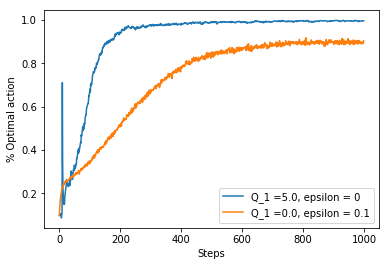

In [10]:
plt.figure()
for i, epsilon in enumerate(epsilons):
    plt.plot(ratio_optimal_action[i], label='Q_1 ='+str(initial_values[i])+', epsilon = '+str(epsilon))
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()

plt.show()

Optimistic initial action-value에 대한 실험결과를 관찰해보자. 초반에 한 번 optimal action selection의 비율이 크게 증가했다가 다시 감소하는 것을 볼 수 있는데, 이는 optimal action이 greedy action으로 선택되었다가 업데이트로 인한 추정값의 degradation으로 인해 어느 순간부터 다른 action들이 greedy action으로서 더 많이 선택되기 때문인 것으로 예측해 볼 수 있다. (Optimal action이라는 것은 분포의 평균값이 높다는 뜻이기 때문에 다른 actions에 비해 업데이트로 인한 degradation이 적을 것이다. 그래서 초반부에 가파른 상승폭을 보이게 된다.) 여기서 눈여겨 봐야 할 점은 $Q_1 = 0, \epsilon = 0.1$ 의 $\epsilon$-greedy 방식이 optimal action을 찾은 이후에도 9%(0.1 * 0.9%)의 확률로 계속해서 탐험(exploration)하는 것에 비해, $\epsilon=0$ 의 optimistic initial action-value에서는 optimal action을 찾은 이후에는 더 이상의 탐험을 하지 않는다는 것이다. 덕분에 더 높은 optimal action selection의 ratio를 보장할 수 있다.

### 2.7 Upper-Confidence-Bound Action Selection

Action value estimate의 정확도는 항상 불확실성을 내포하고 있기 때문에 탐험(exploration)에 대한 중요성이 대두될 수 밖에 없다. 이번 절에서는 탐험(exploration)에 대한, $\epsilon$-greedy method 와는 다른, 방법론에 대해 알아보도록 할 것이다.

$\epsilon$-greedy action selection은 특정 확률로 non-greedy action을 선택함으로써 탐험(exploring)을 하게된다. 헌데, 그 과정에서 어느 action이 greedy action에 가까운지, 혹은 어느 action의 불확실성이 더 높은지까지 자세히 따져보지는 않는다. 이러한 부분을 보완하자는 것이 Upper-confidence-bound action selection(이하 UCB)의 전략이다. UCB는 non-greedy action을 고르는 것에 있어서 현재의 추정치와 더불어 그 불확실성을 함께 고려한다.

$$A_t = argmax_a \big[ Q_t(a) + c \sqrt{\frac{log_e t}{N_t (a)}} \big],$$

* $log_e t$는 t에 대한 자연로그 함수다.
* $N_t(a)$는 t시점 이전에 action a가 선택된 횟수다. $N_t(a) = 0$ 일때는 a에 대한 선택이 최우선으로 고려된다.
* c는 탐험에 대한 정도를 조절하는 hyperparameter에 해당한다. ( $c > 0$ )

UCB는 action value의 추정을 함에 있어 그 불확실성(uncertainty)의 측정에 대한 square-root term이 붙은 모양이라고 볼 수 있다. 쉽게 말해 $\frac{log_e t}{N_t (a)}$의 분자가 분모에 비해 크다면 그만큼 불확실성이 높다는 의미이고, 분모가 분자에 비해 크다면 그만큼 확실성(certainty)이 높다는 의미이다. 여기서 눈여겨볼 점은, 자연로그 함수는 양의 방향으로 발산하는 함수이기 때문에 결국 모든 action은 선택된다는 것이며, 또한 그 증가폭은 시간이 지날수록 줄어들기 때문에 action value에 대한 추정치가 낮다면 차츰 선택되는 빈도가 줄어들게 된다는 것이다. 이는 시간이 오래 지나서도 추정치가 낮은 actions에 대해 optimal action이 아닐 가능성이 크다고 간주하는 것과 같다.

UCB는 상황에 따라 좋은 성능을 내기도 하지만 bandit problem보다 더 복잡한 강화학습 문제(특히 non-stationary 문제)에 대해서는 사용하기 훨씬 어려워진다는 단점이 있다.

### 2.8 Gradient Bandit Algorithms

### References

##### 1. Sutton, R. and Barto, A. (2017). *Reinforcement Learning: An Introduction*. 2nd ed. MIT Press